<a href="https://colab.research.google.com/github/ThatNinjaGuy/Machine-learning-A-Z-Course/blob/main/stock_market_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

def load_data(file_path):
    data = pd.read_csv(file_path)
    data.columns = data.columns.str.strip()
    data['Timestamp'] = pd.to_datetime(data['Timestamp'])
    data.set_index('Timestamp', inplace=True)
    return data

def resample_data(data):
    data_to_resample = data.drop(columns=['Date'])
    resampled_data = data_to_resample.resample('30T').mean()
    return resampled_data

def plot_resampled_data(resampled_data):
    fig, ax = plt.subplots(figsize=(12, 6))
    resampled_data['Close'].plot(ax=ax, title='Stock Prices (Close) - Resampled to 30-Minute Intervals', ylabel='Price')
    plt.show()

def calculate_moving_average(data, window):
    return data['Close'].rolling(window=window).mean()

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

def calculate_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def plot_moving_averages(data, ma_windows):
    fig, axes = plt.subplots(len(ma_windows), 1, figsize=(12, 4 * len(ma_windows)), sharex=True)

    if len(ma_windows) == 1:
        axes = [axes]

    for i, window in enumerate(ma_windows):
        ma = calculate_moving_average(data, window)
        data['Close'].plot(ax=axes[i], label='Close Price', color='blue')
        ma.plot(ax=axes[i], label=f'MA{window}', color='orange')
        axes[i].set_title(f'Moving Average (MA{window})')
        axes[i].set_ylabel(f'MA{window}')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

def plot_macd(macd, signal):
    fig, ax = plt.subplots(figsize=(12, 6))
    macd.plot(ax=ax, label='MACD', color='b')
    signal.plot(ax=ax, label='Signal Line', color='r')
    ax.set_title('MACD')
    ax.legend()
    plt.show()

def plot_rsi(rsi):
    fig, ax = plt.subplots(figsize=(12, 6))
    rsi.plot(ax=ax, label='RSI', color='g')
    ax.axhline(30, linestyle='--', alpha=0.5, color='r')
    ax.axhline(70, linestyle='--', alpha=0.5, color='r')
    ax.set_title('RSI')
    ax.legend()
    plt.show()

def plot_volume(data):
    fig, ax = plt.subplots(figsize=(12, 6))
    data['Volume'].plot(ax=ax, title='Trading Volumes', ylabel='Volume')
    plt.show()

def add_computed_values(data, ma_windows):
    # Calculate Moving Averages
    for window in ma_windows:
        data[f'MA{window}'] = calculate_moving_average(data, window)

    # Calculate MACD and Signal Line
    macd, signal = calculate_macd(data)
    data['MACD'] = macd
    data['Signal'] = signal

    # Calculate RSI
    rsi = calculate_rsi(data)
    data['RSI'] = rsi

    return data


In [2]:
pip install firebase-admin

In [3]:
import firebase_admin
from firebase_admin import credentials, db

# Function to initialize Firebase app
def initialize_firebase():
    if not firebase_admin._apps:
        cred = credentials.Certificate('/content/stockmarket-b9c19-firebase-adminsdk-uqexr-f4be4c7249.json')
        firebase_admin.initialize_app(cred, {
            'databaseURL': 'https://stockmarket-b9c19-default-rtdb.firebaseio.com/'
        })

# Function to upload data to firebase in chunks
def upload_data_to_firebase(data, stock_name):
    # Initialize Firebase app if not already initialized
    initialize_firebase()

    # Reference to the Firebase database
    ref = db.reference('stocks/' + stock_name)

    # Reset the index and convert timestamps to strings
    data.reset_index(inplace=True)  # Reset the index to ensure it's unique
    data['Timestamp'] = data['Timestamp'].astype(str)  # Convert Timestamps to strings

    # Replace out-of-range float values with None
    data = data.replace({float('inf'): None, float('-inf'): None, float('nan'): None})

    # Convert the dataframe to a dictionary
    data_dict = df_to_dict(data)

    # Upload data in chunks
    batch_size = 500  # Adjust batch size as needed
    # for i in range(0, len(data_dict), batch_size):
    #     chunk = dict(list(data_dict.items())[i:i + batch_size])
    #     ref.update(chunk)

    print("Data uploaded to Firebase successfully.")

# Function to convert dataframe to dictionary
def df_to_dict(df):
    return df.to_dict(orient='index')


In [4]:
import numpy as np

def moving_average_signal(data, window):
    signal_col = f'Signal_MA{window}'
    position_col = f'Position_MA{window}'

    data[signal_col] = 'UNINVESTED'
    valid_ma = data[f'MA{window}'].notna()

    # Define buy and sell conditions
    buy_condition = (data['Close'].shift(1) > data[f'MA{window}'].shift(1)) & (data['Close'] <= data[f'MA{window}']) & valid_ma
    sell_condition = (data['Close'].shift(1) < data[f'MA{window}'].shift(1)) & (data['Close'] >= data[f'MA{window}']) & valid_ma

    invested = False

    for i in range(len(data)):
        if i < 2600:
            continue  # Skip the first 2600 records (200 days * 13 data points per day)
        if pd.isna(data['Close'].iloc[i]) or data['Close'].iloc[i] == 0:
            continue  # Skip if Close price is NaN or 0
        if not invested and buy_condition.iloc[i]:
            data.at[data.index[i], signal_col] = 'BUY'
            invested = True
        elif invested and sell_condition.iloc[i]:
            data.at[data.index[i], signal_col] = 'SELL'
            invested = False
        elif invested:
            data.at[data.index[i], signal_col] = 'ALREADY INVESTED'

    data[position_col] = data[signal_col].apply(lambda x: 1 if x == 'BUY' else -1 if x == 'SELL' else 0)
    data[position_col] = data[position_col].diff()

    return data

def rsi_strategy(data, lower_threshold=30, upper_threshold=70):
    data['Signal_RSI'] = 'UNINVESTED'
    valid_rsi = data['RSI'].notna()
    buy_condition = (data['RSI'] < lower_threshold) & valid_rsi
    sell_condition = (data['RSI'] > upper_threshold) & valid_rsi

    invested = False

    for i in range(len(data)):
        if i < 2600:
            continue  # Skip the first 2600 records (200 days * 13 data points per day)
        if pd.isna(data['Close'].iloc[i]) or data['Close'].iloc[i] == 0:
            continue  # Skip if Close price is NaN or 0
        if not invested and buy_condition.iloc[i]:
            data.at[data.index[i], 'Signal_RSI'] = 'BUY'
            invested = True
        elif invested and sell_condition.iloc[i]:
            data.at[data.index[i], 'Signal_RSI'] = 'SELL'
            invested = False
        elif invested:
            data.at[data.index[i], 'Signal_RSI'] = 'ALREADY INVESTED'

    data['Position_RSI'] = data['Signal_RSI'].apply(lambda x: 1 if x == 'BUY' else -1 if x == 'SELL' else 0)
    data['Position_RSI'] = data['Position_RSI'].diff()

    return data


In [5]:
def backtest_strategy(data, signal_col, portfolio_col, initial_cash=10000):
    cash = initial_cash
    holdings = 0
    portfolio_value = []

    for i in range(len(data)):
        close_price = data['Close'].iloc[i]

        if close_price == 0 or pd.isna(close_price):
            portfolio_value.append(cash + holdings * close_price)
            continue

        if data[signal_col].iloc[i] == 'BUY':
            if cash > 0:
                holdings = cash / close_price
                cash = 0
        elif data[signal_col].iloc[i] == 'SELL':
            if holdings > 0:
                cash = holdings * close_price
                holdings = 0
        portfolio_value.append(cash + holdings * close_price)

    data[portfolio_col] = portfolio_value
    total_gain = portfolio_value[-1] - initial_cash
    return data, total_gain


In [8]:
def load_and_prepare_data(file_path, ma_windows):
    data = load_data(file_path)
    resampled_data = resample_data(data)
    plot_resampled_data(resampled_data)

    data_with_values = add_computed_values(data, ma_windows)
    data_with_values.sort_index(inplace=True)

    return data_with_values

In [9]:
def save_and_upload_data(all_strategies_data, stock_name):
    output_file_path = '/content/' + stock_name + '_with_strategies.csv'
    all_strategies_data.to_csv(output_file_path, index=False)
    print(f"Data with strategies saved to {output_file_path}")

    upload_data_to_firebase(all_strategies_data, stock_name)

def plot_indicators(data_with_values, ma_windows):
    plot_moving_averages(data_with_values, ma_windows)
    plot_macd(data_with_values['MACD'], data_with_values['Signal'])
    plot_rsi(data_with_values['RSI'])
    plot_volume(data_with_values)

In [10]:
def apply_strategies_and_backtest(data_with_values, ma_windows):
    all_strategies_data = data_with_values.copy()

    print("Backtesting Moving Average Strategies with Close Price...")
    for window in ma_windows:
        data_with_strategy = moving_average_signal(data_with_values.copy(), window)
        data_with_strategy, total_gain = backtest_strategy(
            data_with_strategy, f'Signal_MA{window}', f'Portfolio_MA{window}', initial_cash=10000
        )
        print(f'Total gain from Close Price and MA{window} strategy: ${total_gain:.2f}')
        all_strategies_data = all_strategies_data.join(data_with_strategy[[f'Signal_MA{window}', f'Position_MA{window}', f'Portfolio_MA{window}']], how='left')

    print("Backtesting RSI Strategy...")
    data_with_strategy = rsi_strategy(data_with_values.copy(), 30, 70)
    data_with_strategy, total_gain_rsi = backtest_strategy(data_with_strategy, 'Signal_RSI', 'Portfolio_RSI', initial_cash=10000)
    print(f'Total gain from RSI strategy: ${total_gain_rsi:.2f}')
    all_strategies_data = all_strategies_data.join(data_with_strategy[['Signal_RSI', 'Position_RSI', 'Portfolio_RSI']], how='left')

    all_strategies_data.sort_index(inplace=True)

    return all_strategies_data


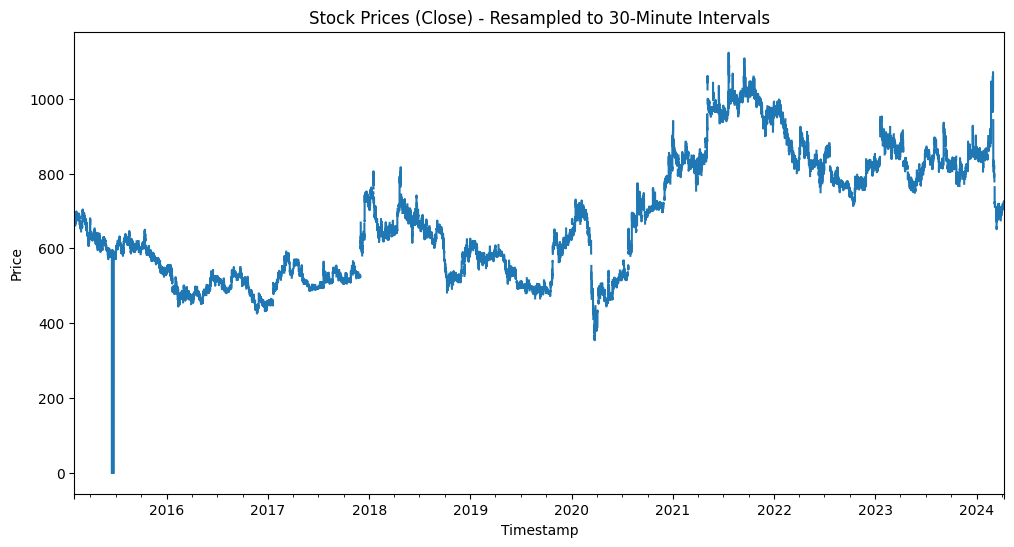

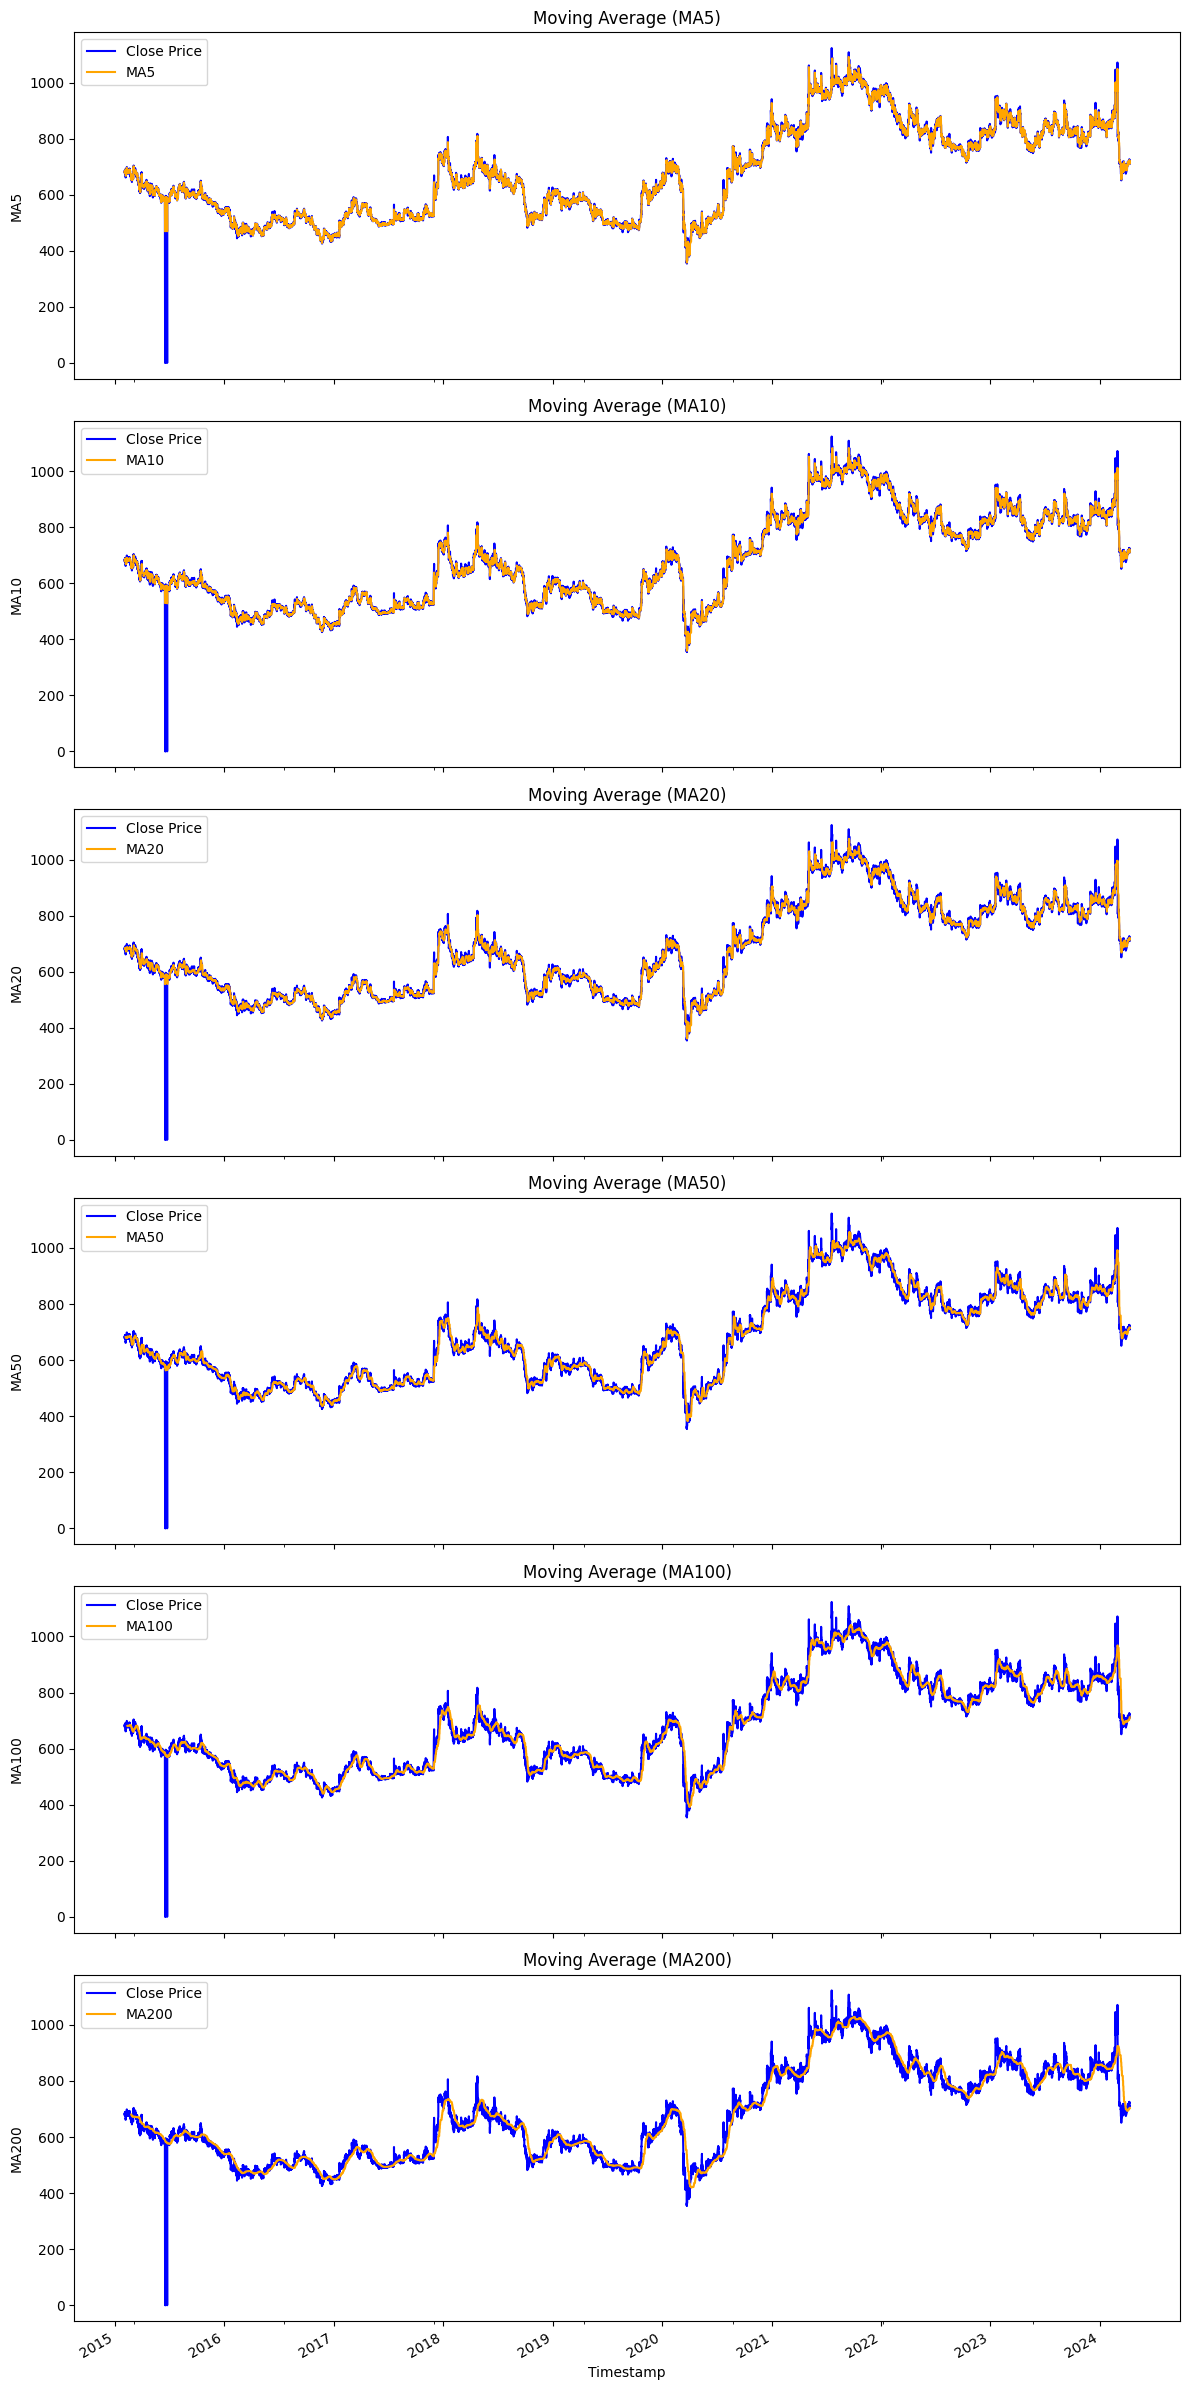

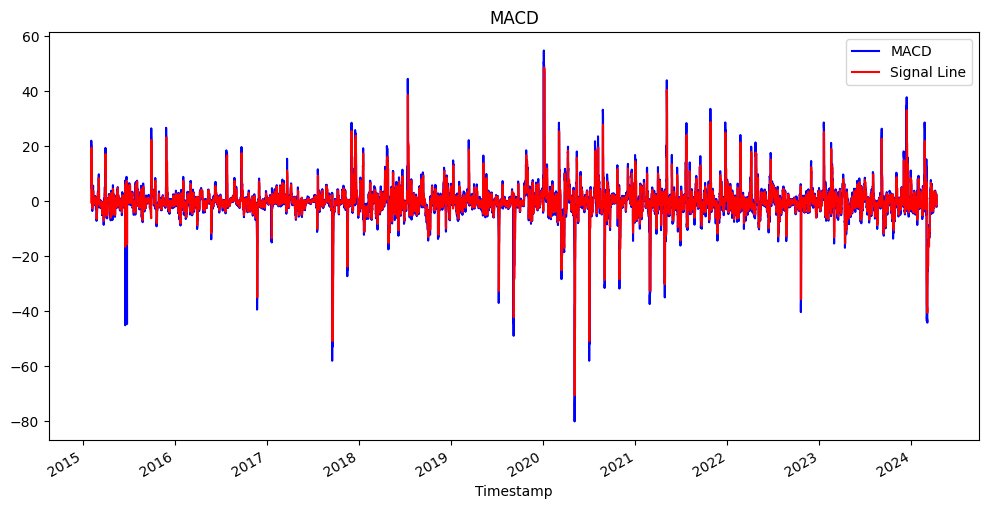

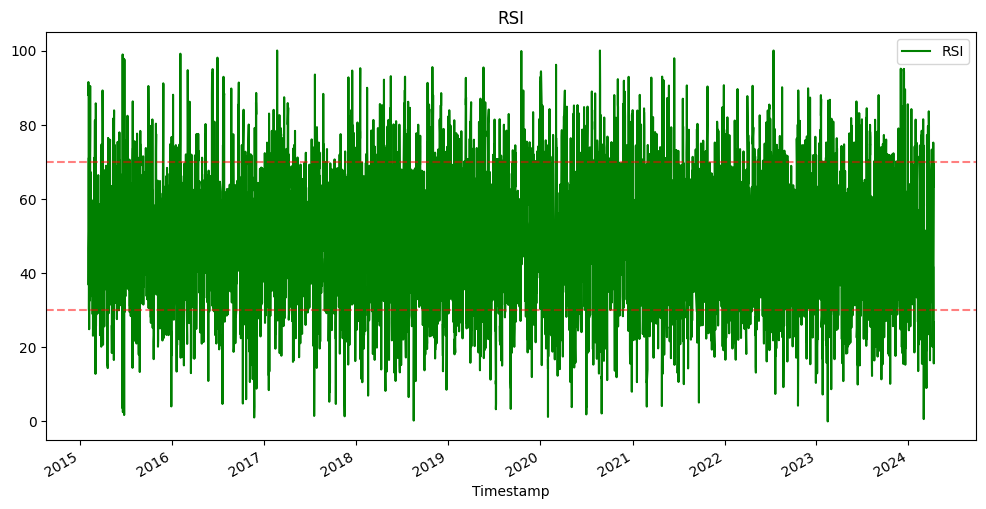

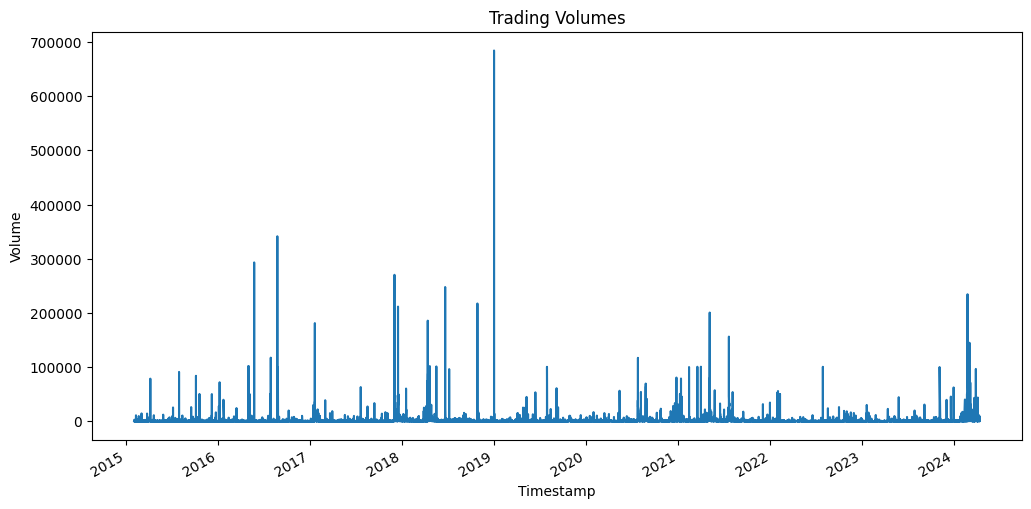

                                                   Date    Open   Close  \
Timestamp                                                                 
2015-02-02 09:15:00+05:30   Monday-02-Feb-2015 09:15:00  676.00  680.00   
2015-02-02 09:45:00+05:30   Monday-02-Feb-2015 09:45:00  680.00  678.00   
2015-02-02 10:15:00+05:30   Monday-02-Feb-2015 10:15:00  678.00  678.00   
2015-02-02 10:45:00+05:30   Monday-02-Feb-2015 10:45:00  678.00  682.95   
2015-02-02 11:15:00+05:30   Monday-02-Feb-2015 11:15:00  682.95  683.50   

                             Low   High  Volume     MA5     MA10      MA20  \
Timestamp                                                                    
2015-02-02 09:15:00+05:30  676.0  680.7    66.0  614.12  606.990  603.3875   
2015-02-02 09:45:00+05:30  678.0  687.0   276.0  630.32  614.840  607.1875   
2015-02-02 10:15:00+05:30  678.0  678.0    27.0  646.58  622.660  611.0375   
2015-02-02 10:45:00+05:30  678.0  684.4   385.0  663.19  630.955  615.1350   
2015-0

In [11]:
def main():
    stock_name = 'AGRO_TECH_FOODS'
    file_path = '/content/' + stock_name + '.csv'
    ma_windows = [5, 10, 20, 50, 100, 200]

    data_with_values = load_and_prepare_data(file_path, ma_windows)
    plot_indicators(data_with_values, ma_windows)

    print(data_with_values.head())  # Display the first few rows to verify the added columns

    all_strategies_data = apply_strategies_and_backtest(data_with_values, ma_windows)

    print(all_strategies_data.head())  # Display the updated dataframe with signals and portfolio values

    save_and_upload_data(all_strategies_data, stock_name)

if __name__ == "__main__":
    main()
